In [1]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras import datasets, layers, models
from keras.utils import np_utils
from keras import regularizers
from keras.layers import Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
def unpickle(file):
    """load the cifar-10 data"""

    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data


def load_cifar_10_data(data_dir, negatives=False):
    """
    Return train_data, train_filenames, train_labels, test_data, test_filenames, test_labels
    """

    # get the meta_data_dict
    # num_cases_per_batch: 1000
    # label_names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    # num_vis: :3072

    meta_data_dict = unpickle(data_dir + "/batches.meta")
    cifar_label_names = meta_data_dict[b'label_names']
    cifar_label_names = np.array(cifar_label_names)

    # training data
    cifar_train_data = None
    cifar_train_filenames = []
    cifar_train_labels = []

    # cifar_train_data_dict
    # 'batch_label': 'training batch 5 of 5'
    # 'data': ndarray
    # 'filenames': list
    # 'labels': list

    for i in range(1, 6):
        cifar_train_data_dict = unpickle(data_dir + "/data_batch_{}".format(i))
        if i == 1:
            cifar_train_data = cifar_train_data_dict[b'data']
        else:
            cifar_train_data = np.vstack((cifar_train_data, cifar_train_data_dict[b'data']))
        cifar_train_filenames += cifar_train_data_dict[b'filenames']
        cifar_train_labels += cifar_train_data_dict[b'labels']

    cifar_train_data = cifar_train_data.reshape((len(cifar_train_data), 3, 32, 32))
    if negatives:
        cifar_train_data = cifar_train_data.transpose(0, 2, 3, 1).astype(np.float32)
    else:
        cifar_train_data = np.rollaxis(cifar_train_data, 1, 4)
    cifar_train_filenames = np.array(cifar_train_filenames)
    cifar_train_labels = np.array(cifar_train_labels)

    # test data
    # cifar_test_data_dict
    # 'batch_label': 'testing batch 1 of 1'
    # 'data': ndarray
    # 'filenames': list
    # 'labels': list

    cifar_test_data_dict = unpickle(data_dir + "/test_batch")
    cifar_test_data = cifar_test_data_dict[b'data']
    cifar_test_filenames = cifar_test_data_dict[b'filenames']
    cifar_test_labels = cifar_test_data_dict[b'labels']

    cifar_test_data = cifar_test_data.reshape((len(cifar_test_data), 3, 32, 32))
    if negatives:
        cifar_test_data = cifar_test_data.transpose(0, 2, 3, 1).astype(np.float32)
    else:
        cifar_test_data = np.rollaxis(cifar_test_data, 1, 4)
    cifar_test_filenames = np.array(cifar_test_filenames)
    cifar_test_labels = np.array(cifar_test_labels)

    return cifar_train_data, cifar_train_filenames, cifar_train_labels, \
        cifar_test_data, cifar_test_filenames, cifar_test_labels, cifar_label_names

Train data:  (50000, 32, 32, 3)
Train filenames:  (50000,)
Train labels:  (50000,)
Test data:  (10000, 32, 32, 3)
Test filenames:  (10000,)
Test labels:  (10000,)
Label names:  (10,)


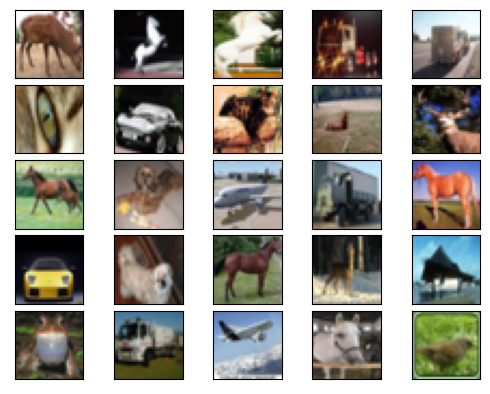

In [4]:
cifar_10_dir = 'cifar-10-batches-py'
train_images, train_filenames, train_labels, test_images, test_filenames, test_labels, label_names = \
    load_cifar_10_data(cifar_10_dir)

print("Train data: ", train_images.shape)
print("Train filenames: ", train_filenames.shape)
print("Train labels: ", train_labels.shape)
print("Test data: ", test_images.shape)
print("Test filenames: ", test_filenames.shape)
print("Test labels: ", test_labels.shape)
print("Label names: ", label_names.shape)

# Don't forget that the label_names and filesnames are in binary and need conversion if used.

# display some random training images in a 25x25 grid
num_plot = 5
f, ax = plt.subplots(num_plot, num_plot)
for m in range(num_plot):
    for n in range(num_plot):
        idx = np.random.randint(0, train_images.shape[0])
        ax[m, n].imshow(train_images[idx])
        ax[m, n].get_xaxis().set_visible(False)
        ax[m, n].get_yaxis().set_visible(False)
f.subplots_adjust(hspace=0.1)
f.subplots_adjust(wspace=0)
plt.show()

In [12]:
num_classes = 10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [31]:
train_labels_cat = np_utils.to_categorical(train_labels, num_classes)
test_labels_cat = np_utils.to_categorical(test_labels, num_classes)

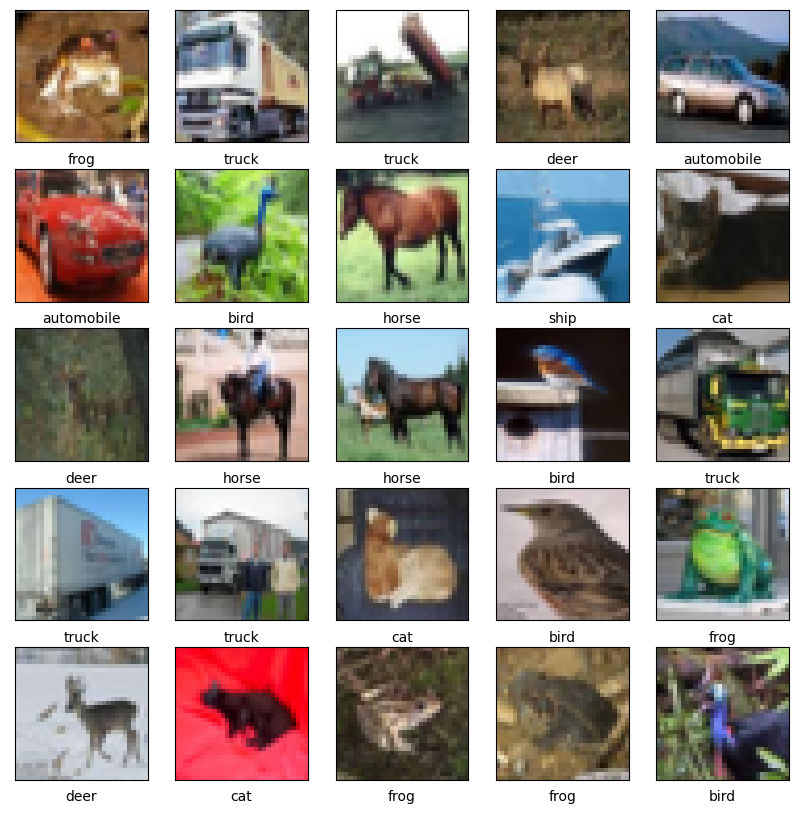

In [9]:
plt.figure(figsize=[10,10])
for i in range(25):    # for first 25 images
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

plt.show()

In [10]:
train_images = train_images.astype('float16')
train_images /= 255

test_images = test_images.astype('float16')
test_images /= 255

In [34]:
# Creating a sequential model and adding layers to it

model = Sequential()

model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))    # num_classes = 10

# Checking the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_14 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_15 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

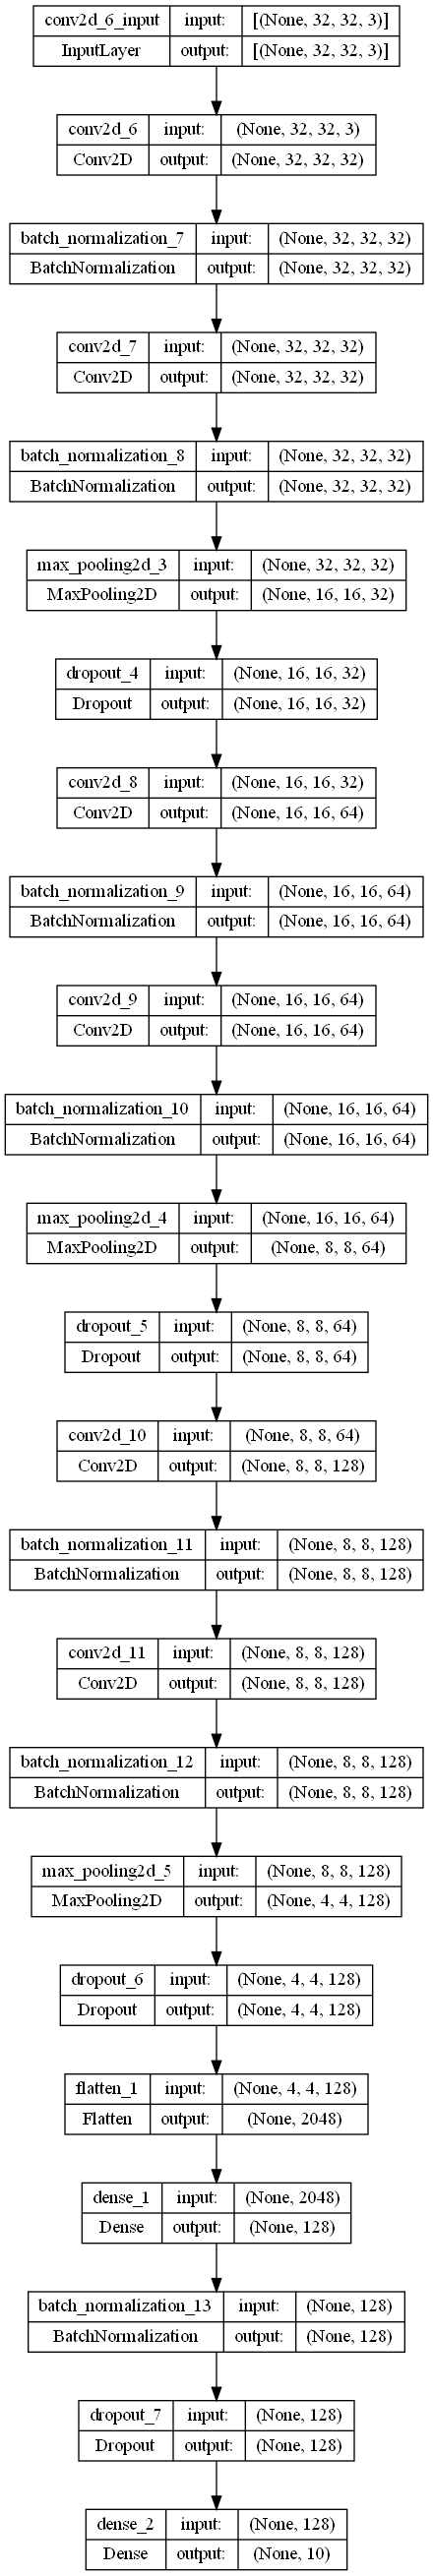

In [14]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

In [35]:
model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [26]:
%pip install visualkeras

     --------------------------------------- 43.2/43.2 kB 41.4 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [27]:
import visualkeras
from collections import defaultdict

In [28]:
color_map = defaultdict(dict)
color_map[layers.Conv2D]['fill'] = '#b71540'
color_map[layers.BatchNormalization]['fill'] = '#f8c291'
color_map[layers.Dropout]['fill'] = '#00aaa0'
color_map[layers.MaxPooling2D]['fill'] = '#8ed2c9'
color_map[layers.Dense]['fill'] = '#462066'
color_map[layers.Flatten]['fill'] = '#95afc0'

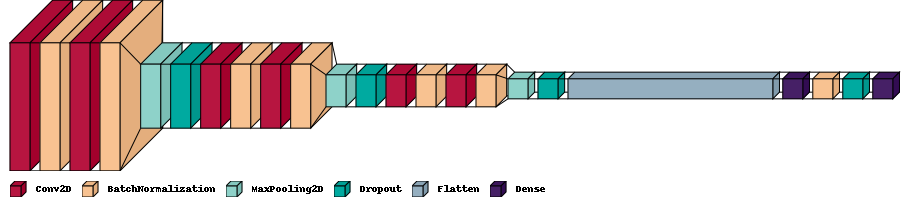

In [29]:
visualkeras.layered_view(model, legend=True, color_map=color_map)

In [36]:
history = model.fit(train_images, train_labels_cat, batch_size=64, epochs=95,
                    validation_data=(test_images, test_labels_cat))

Epoch 1/95
782/782 [==============================] - 10s 11ms/step - loss: 1.7391 - accuracy: 0.4001 - val_loss: 1.5092 - val_accuracy: 0.4698
Epoch 2/95
782/782 [==============================] - 8s 10ms/step - loss: 1.1575 - accuracy: 0.5886 - val_loss: 0.9277 - val_accuracy: 0.6669
Epoch 3/95
782/782 [==============================] - 9s 11ms/step - loss: 0.9743 - accuracy: 0.6603 - val_loss: 0.8272 - val_accuracy: 0.7066
Epoch 4/95
782/782 [==============================] - 8s 11ms/step - loss: 0.8778 - accuracy: 0.6907 - val_loss: 0.9364 - val_accuracy: 0.6627
Epoch 5/95
782/782 [==============================] - 9s 11ms/step - loss: 0.8141 - accuracy: 0.7173 - val_loss: 0.7390 - val_accuracy: 0.7407
Epoch 6/95
782/782 [==============================] - 8s 11ms/step - loss: 0.7640 - accuracy: 0.7355 - val_loss: 0.7739 - val_accuracy: 0.7392
Epoch 7/95
782/782 [==============================] - 8s 11ms/step - loss: 0.7182 - accuracy: 0.7522 - val_loss: 0.6112 - val_accuracy: 0.787

Epoch 58/95
782/782 [==============================] - 9s 12ms/step - loss: 0.3111 - accuracy: 0.8924 - val_loss: 0.4284 - val_accuracy: 0.8675
Epoch 59/95
782/782 [==============================] - 9s 11ms/step - loss: 0.3092 - accuracy: 0.8933 - val_loss: 0.4540 - val_accuracy: 0.8602
Epoch 60/95
782/782 [==============================] - 9s 11ms/step - loss: 0.3053 - accuracy: 0.8945 - val_loss: 0.4245 - val_accuracy: 0.8715
Epoch 61/95
782/782 [==============================] - 9s 11ms/step - loss: 0.3033 - accuracy: 0.8944 - val_loss: 0.4415 - val_accuracy: 0.8631
Epoch 62/95
782/782 [==============================] - 9s 11ms/step - loss: 0.2955 - accuracy: 0.8976 - val_loss: 0.3964 - val_accuracy: 0.8749
Epoch 63/95
782/782 [==============================] - 9s 11ms/step - loss: 0.2962 - accuracy: 0.8981 - val_loss: 0.3990 - val_accuracy: 0.8733
Epoch 64/95
782/782 [==============================] - 9s 11ms/step - loss: 0.2963 - accuracy: 0.8979 - val_loss: 0.3983 - val_accuracy:

In [ ]:
model.save("model-1.h5")

In [17]:
from keras.models import load_model
model_new = load_model("model-0.h5")

In [ ]:
# Loss curve
plt.figure(figsize=[6,4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

In [ ]:
# Accuracy curve
plt.figure(figsize=[6,4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

In [ ]:
# Making the Predictions
pred = model.predict(test_images)
print(pred)

# Converting the predictions into label index 
pred_classes = np.argmax(pred, axis=1)
print(pred_classes)

In [21]:
train_labels_cat.shape

(50000, 10)

In [20]:
train_labels_cat = np_utils.to_categorical(train_labels, num_classes)
test_labels_cat = np_utils.to_categorical(test_labels, num_classes)

In [23]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model_new.evaluate(test_images, test_labels_cat, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
79/79 [==============================] - 4s 6ms/step - loss: 0.4025 - accuracy: 0.8754
test loss, test acc: [0.40247973799705505, 0.8754000067710876]


In [ ]:
# Plotting the Actual vs. Predicted results

fig, axes = plt.subplots(5, 5, figsize=(15,15))
axes = axes.ravel()

for i in np.arange(0, 25):
    axes[i].imshow(test_images[i])
    axes[i].set_title("True: %s \nPredict: %s" % (class_names[np.argmax(test_labels[i])], class_names[pred_classes[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)